#Microstructure Analysis using Image Processing


                   
In this project I have used image processing technique in a polycrystalline microstructure to determined the location of grain boundaries and triple point junction.

###The steps involved in the image processing:




1.   Converting a microstructure into a binary image.
2.   Removing of all the internal grain noice (pits and precipitates), by applying morphological operations.
3.  Convert the grain boundaries into a single line pixel (Skeletonize image).
4.   Locate the triple point junction.
5.   Get the co-ordinate of grain boundary pixels starting from each triple points.



In [ ]:
#import all the necessery packages
import numpy as np
import scipy.ndimage as ndi
from skimage import color, filters, morphology, measure
import imageio as io
import scipy.ndimage
import matplotlib.pyplot as plt
import cv2 as cv
from scipy import ndimage


Here I am using a random polycrystalline image for the purpose of locating the co-ordinates of triple point junction of the microstructure.



(411, 600) uint8


<ipython-input-5-789cf171aa5f>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = io.imread('/content/image.jpeg')


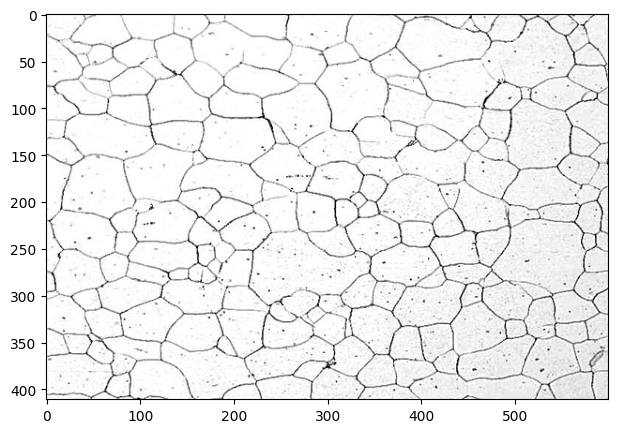

In [ ]:
#image
img = io.imread('/content/image.jpeg')
print(img.shape, img.dtype)
img = img.astype(np.uint8)
plt.figure(figsize= (12,5))
plt.imshow(img, cmap='gray')

Now, to remove all the noice form image, I have applied the morphological operations. For applying morphological operations I first converted my image into a binary image. Cummulitive distribution function is used to determining the threshold value for binary image. \\
*Note*: In binary image all the white pixels corresponds to foreground pixel and black piexel corresponds to background pixel .

In [ ]:
def histogram(img, normalized = True):
    freq_hist = ndi.histogram(img, 0, 255, 256)
    bins = np.array([i for i in range (256)])
    cdf = np.cumsum(freq_hist)
    if normalized:
       n = np.sum(freq_hist)
       freq_hist = freq_hist/n
       cdf = cdf/n
       t = filters.threshold_otsu(img)
    plt.bar(bins, freq_hist)
    plt.vlines(t, 0.0, 0.02, colors = 'blue')
    return t

185


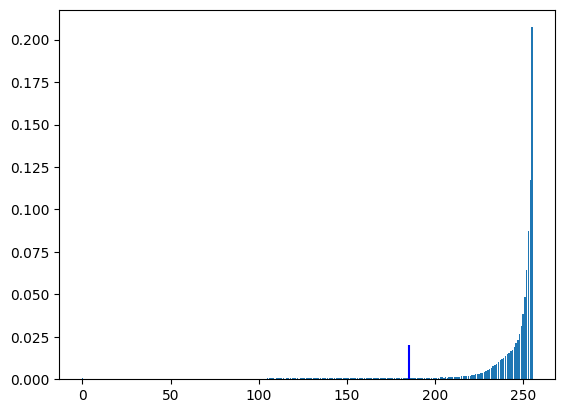

In [ ]:
t = histogram(img)
print(t)

[[ True False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


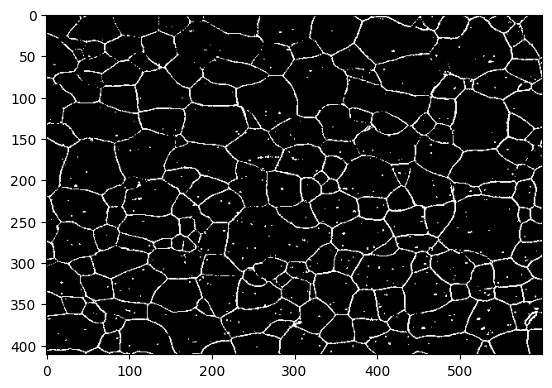

In [ ]:
#show binary image
binary = img <= t
print(binary)
plt.figure
plt.imshow(binary, cmap='gray')

To reduce the noices from the above image and to thin down the foreground pixels ( grain boundary pixels) in to a single pixel,  four different type of morphological operations are applied:




1.   Dilation
2.   Erosion
3.   Reconstruction.
4.   Thinning

[[0 1 0]
 [1 1 1]
 [0 1 0]]


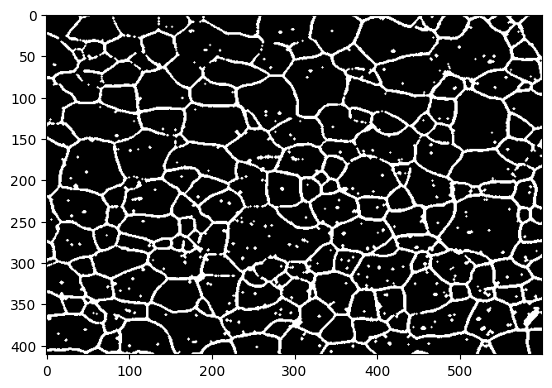

In [ ]:
selem = np.array([[0,1,0],[1,1,1],[0,1,0]])
print(selem)
img_1 = morphology.binary_dilation(binary, selem)
img_2 = morphology.binary_dilation(img_1, selem)
img_3 = morphology.binary_erosion(img_2, selem)
img_4 = morphology.binary_dilation(img_3, selem)
img_5 = morphology.binary_erosion(img_4, selem)

plt.figure

plt.imshow(img_5,cmap='gray')


The above binary image is a result of combination of dilation and erosion operations. Now in this image we can see all the grain boundaries clearly. But the problem is it still contains noice in it. In order to remove noice from this, a reconstruction operation is performed on the image.


343


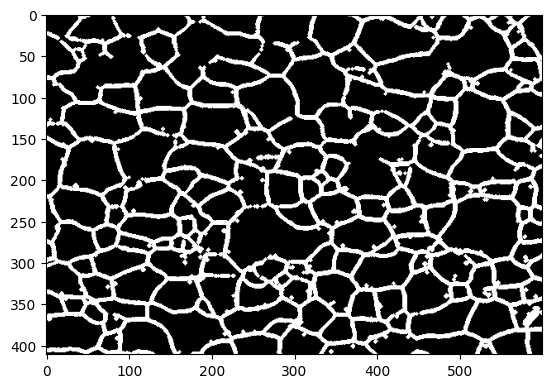

In [ ]:
seed = img_4.copy()
seed[1:-1, 1:-1] = img_4.min()
seed_last = np.full((img_4.shape[0], img_4.shape[1]), False)
mask = img_4.copy()
n = 0
while  (not np.array_equal(seed, seed_last) and n <=500):
    n +=1
    seed_last = seed.copy()
    seed = np.logical_and(morphology.dilation(seed_last, selem), mask)
print(n)
plt.figure()

plt.imshow(seed, cmap='gray')

Noice is completely removed from the image. Now thinning operation is being used to get single pixel grain bounadaries.

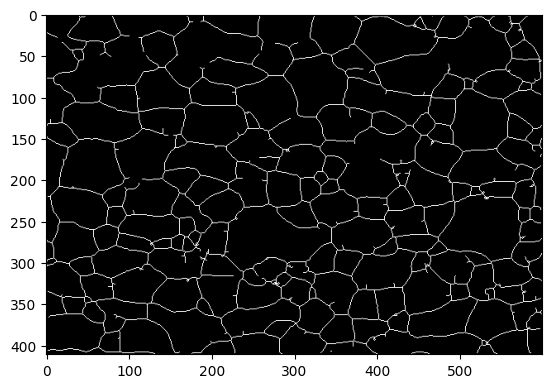

In [ ]:
thinned = morphology.skeletonize(seed)
plt.figure
plt.imshow(thinned, cmap = 'gray')

#Triple Junction location
After skeletonization of the image,the next step is to determine the triple junction location. To do so, Hit and Miss transformation with different structuring element(which make a triple boundary junction) must be run in all orientations so 16 hit-and-miss passes are required. Example of structuring elements are:

 $\begin{pmatrix}
  0 & 1& 0\\
  1 & 1& 0\\
  0 & 1 & 0
\end{pmatrix}$
 $\begin{pmatrix}
  1 & 0& 1\\
  0 & 1& 0\\
  0 & 1 & 0
\end{pmatrix}$
 $\begin{pmatrix}
  0 & 0& 1\\
  0 & 1& 0\\
  1 & 0 & 1
\end{pmatrix}$
 $\begin{pmatrix}
  0 & 0& 1\\
  1 & 1& 0\\
  0 & 1 & 0
\end{pmatrix}$



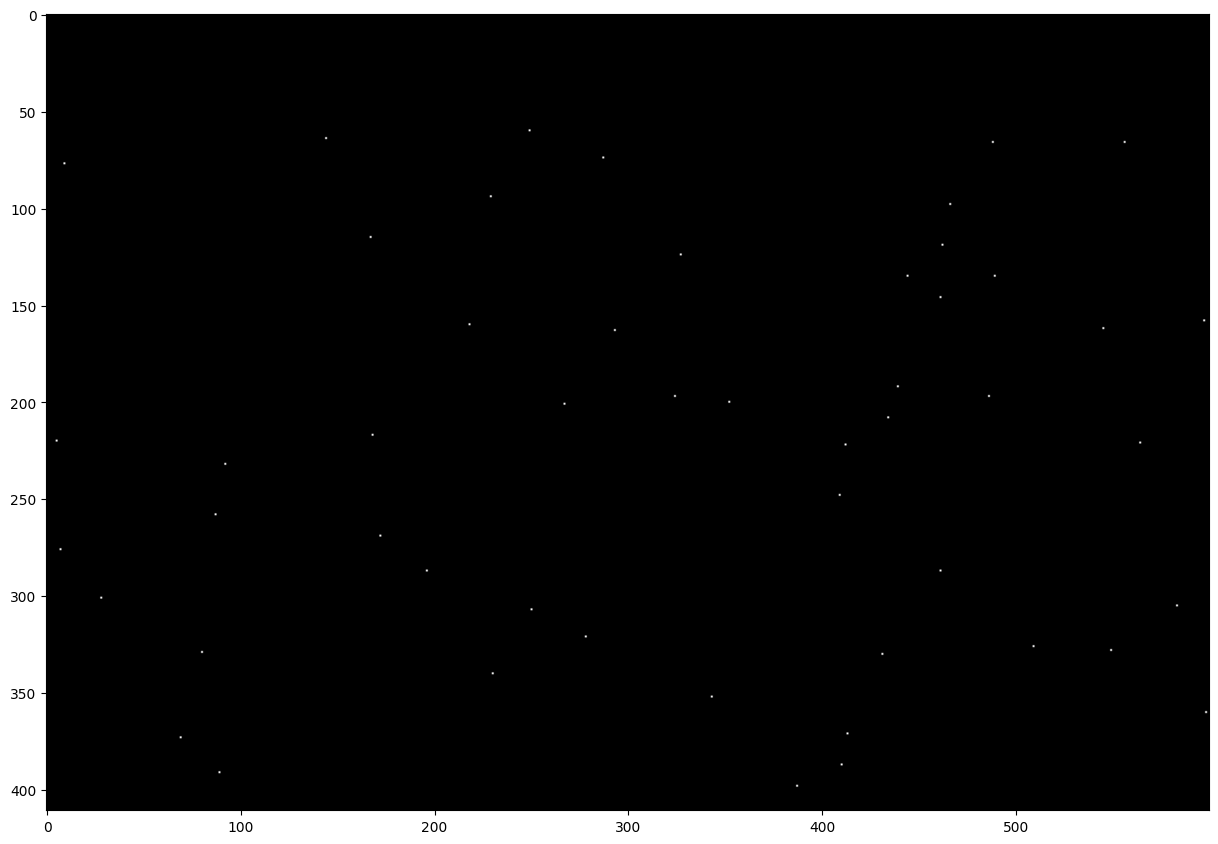

In [ ]:

# Construct the structuring element
s1 = np.array((
        [0, 1, 0],
        [1, 1, 0],
        [0, 1, 0]), dtype="int")


# Apply hit-or-miss transformation
img_s1_1 = ndimage.binary_hit_or_miss(thinned, structure1=s1).astype(int)
plt.figure(figsize=(15,15))
plt.imshow(img_s1_1, cmap = 'gray')

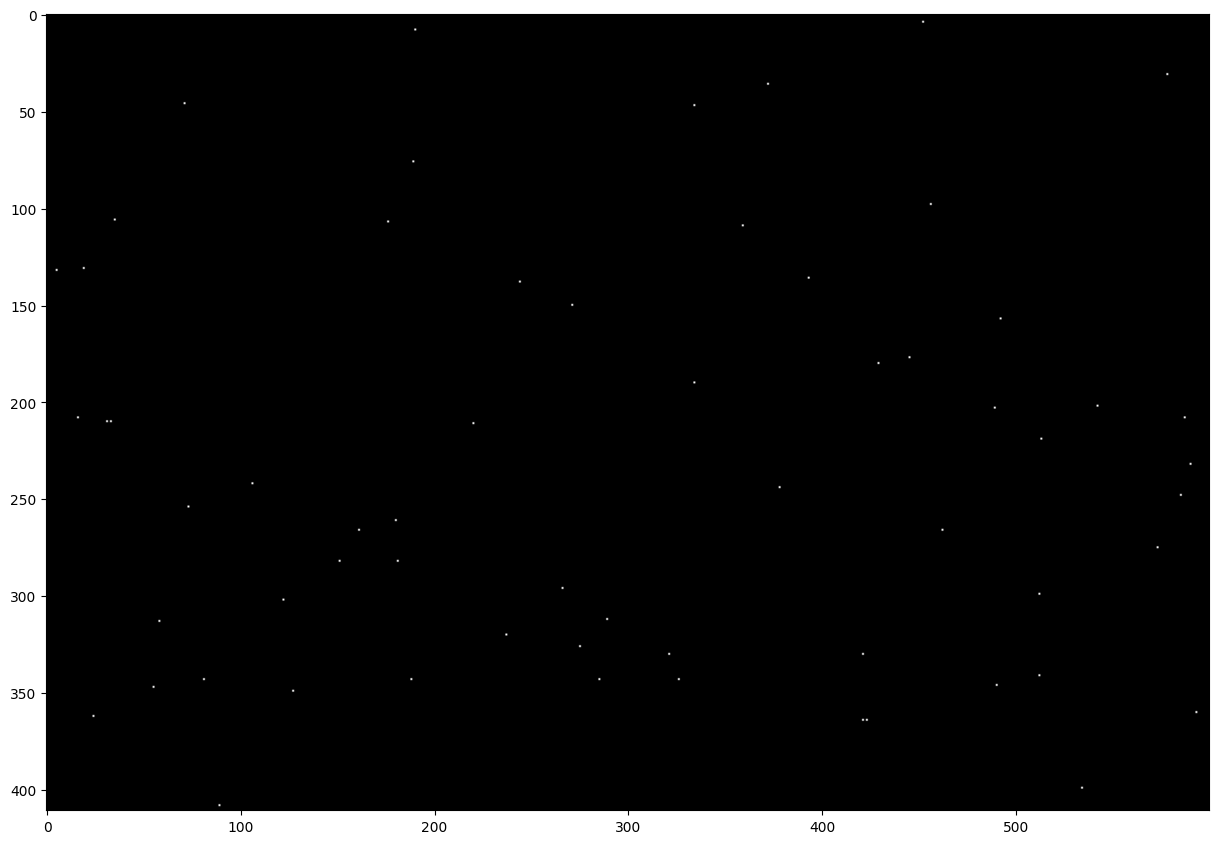

In [ ]:
# Construct the structuring element
s2 = np.array((
        [0, 1, 0],
        [1, 1, 1],
        [0, 0, 0]), dtype="int")


# Apply hit-or-miss transformation
img_s1_2 = ndimage.binary_hit_or_miss(thinned, structure1=s2).astype(int)
plt.figure(figsize=(15,15))
plt.imshow(img_s1_2, cmap = 'gray')

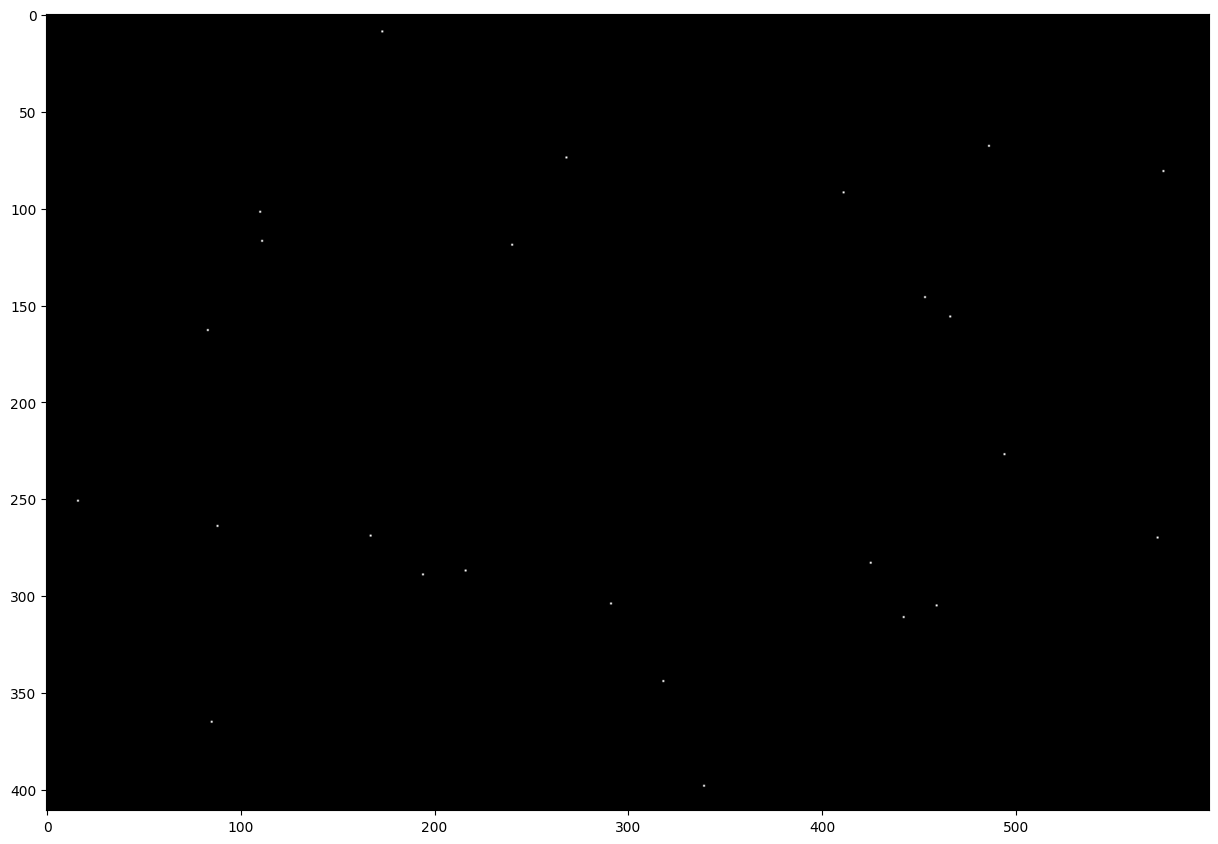

In [ ]:
# Construct the structuring element
s3 = np.array((
        [0, 1, 0],
        [0, 1, 1],
        [0, 1, 0]), dtype="int")


# Apply hit-or-miss transformation
img_s1_3 = ndimage.binary_hit_or_miss(thinned, structure1=s3).astype(int)
plt.figure(figsize=(15,15))
plt.imshow(img_s1_3, cmap = 'gray')

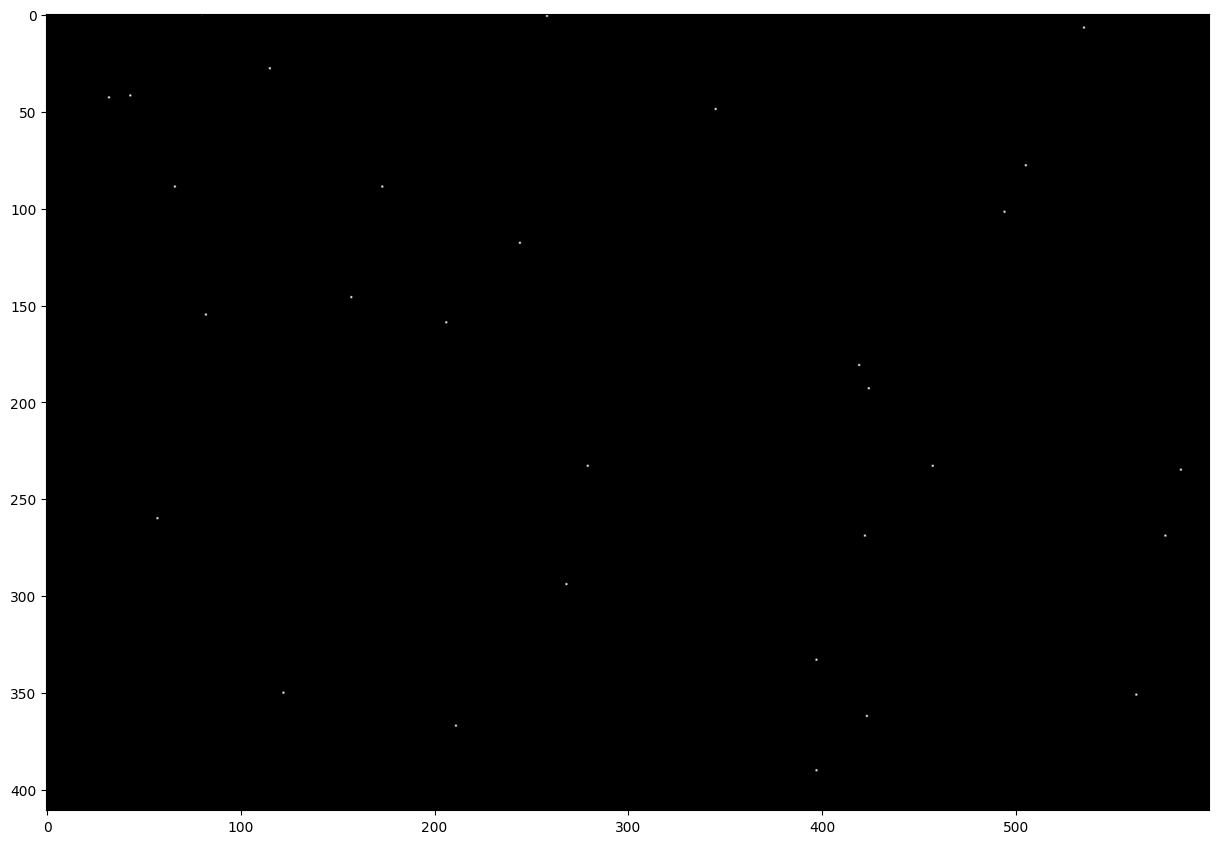

In [ ]:
# Construct the structuring element
s4 = np.array((
        [0, 0, 0],
        [1, 1, 1],
        [0, 1, 0]), dtype="int")


# Apply hit-or-miss transformation
img_s1_4 = ndimage.binary_hit_or_miss(thinned, structure1=s4).astype(int)
plt.figure(figsize=(15,15))
plt.imshow(img_s1_4, cmap = 'gray')

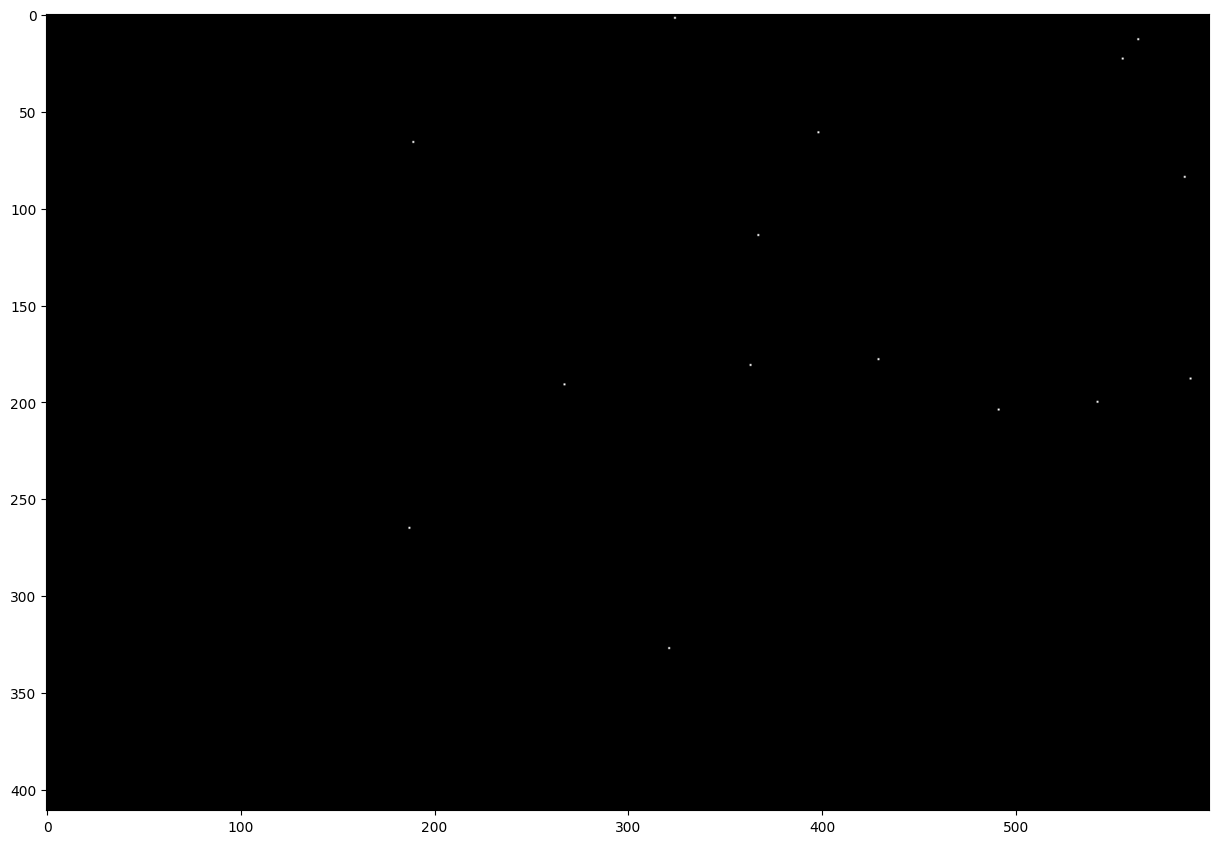

In [ ]:
# Construct the structuring element
s5 = np.array((
        [1, 0, 1],
        [0, 1, 0],
        [0, 1, 0]), dtype="int")


# Apply hit-or-miss transformation
img_s2_1 = ndimage.binary_hit_or_miss(thinned, structure1=s5).astype(int)
plt.figure(figsize=(15,15))
plt.imshow(img_s2_1, cmap = 'gray')

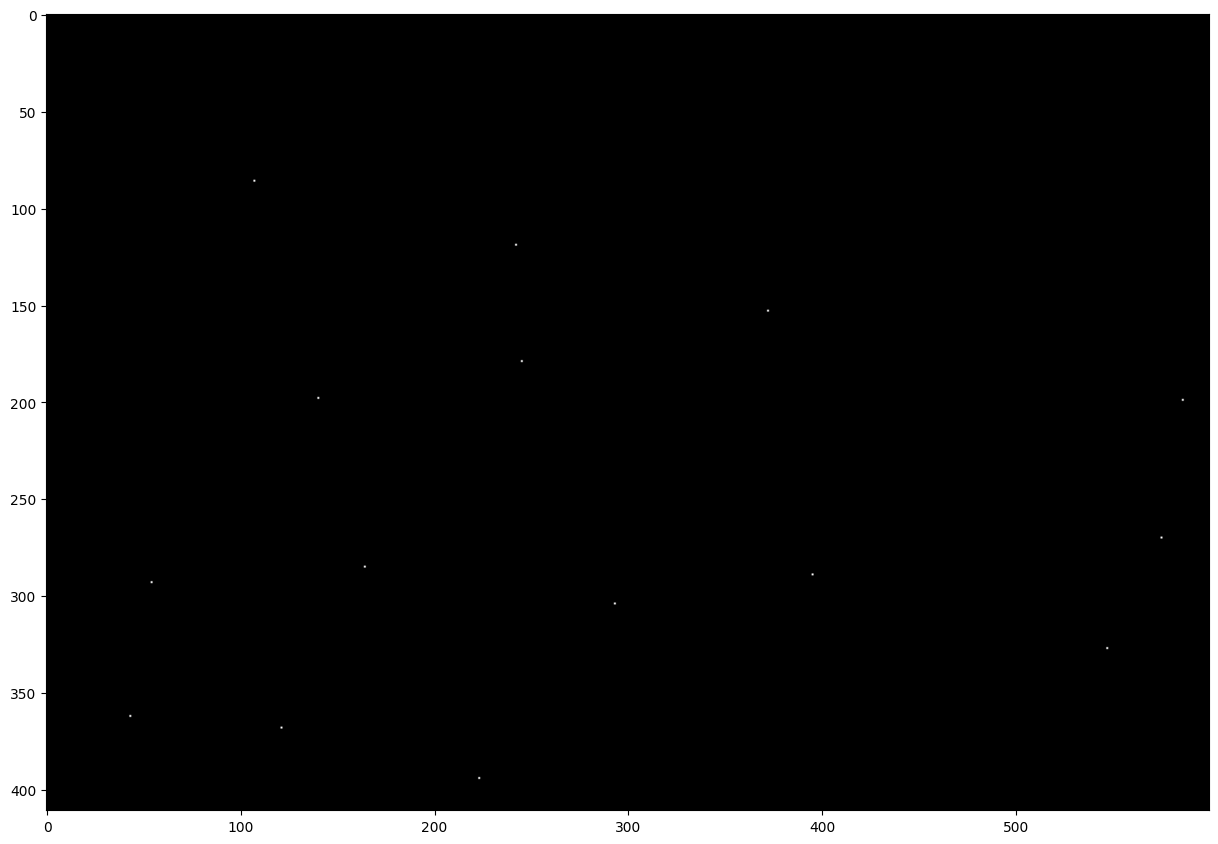

In [ ]:
# Construct the structuring element
s6 = np.array((
        [0, 0, 1],
        [1, 1, 0],
        [0, 0, 1]), dtype="int")


# Apply hit-or-miss transformation
img_s2_2 = ndimage.binary_hit_or_miss(thinned, structure1=s6).astype(int)
plt.figure(figsize=(15,15))
plt.imshow(img_s2_2, cmap = 'gray')

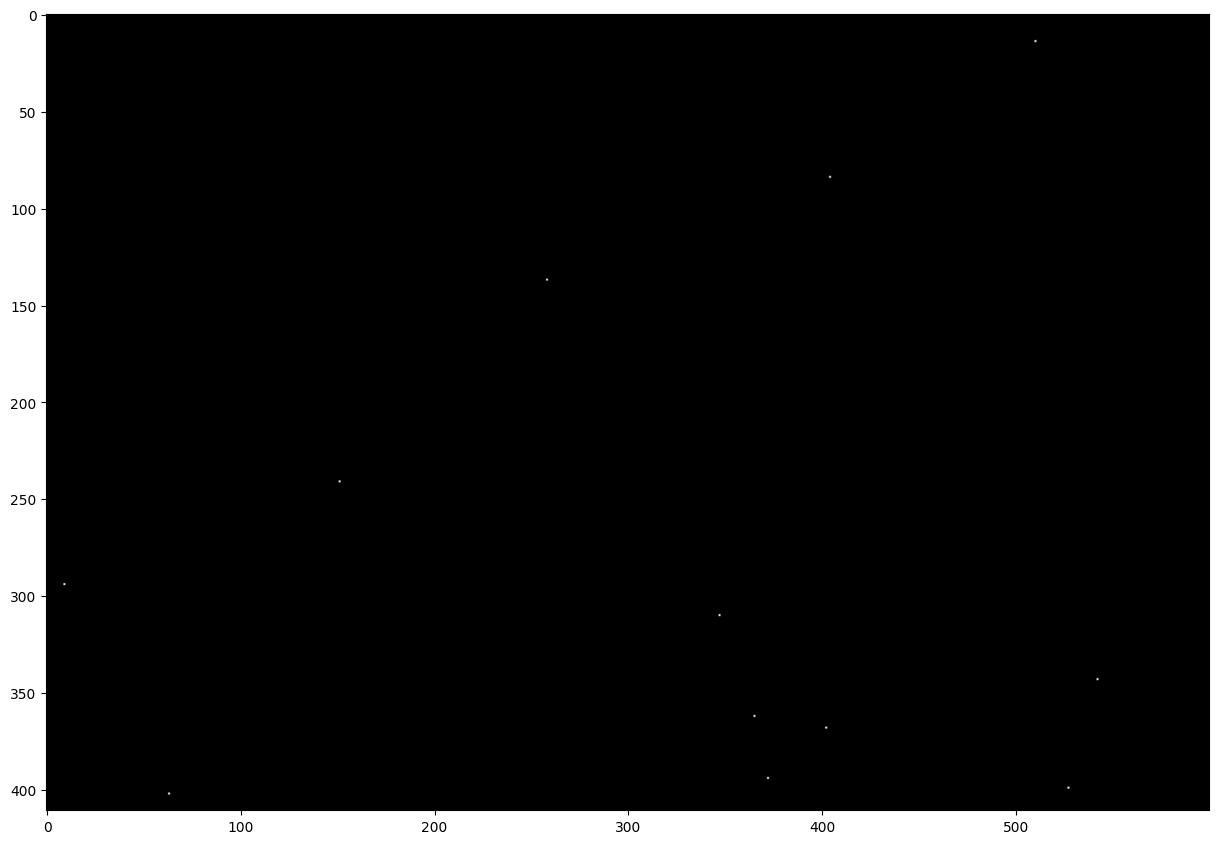

In [ ]:
# Construct the structuring element
s7 = np.array((
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 1]), dtype="int")


# Apply hit-or-miss transformation
img_s2_3 = ndimage.binary_hit_or_miss(thinned, structure1=s7).astype(int)
plt.figure(figsize=(15,15))
plt.imshow(img_s2_3, cmap = 'gray')

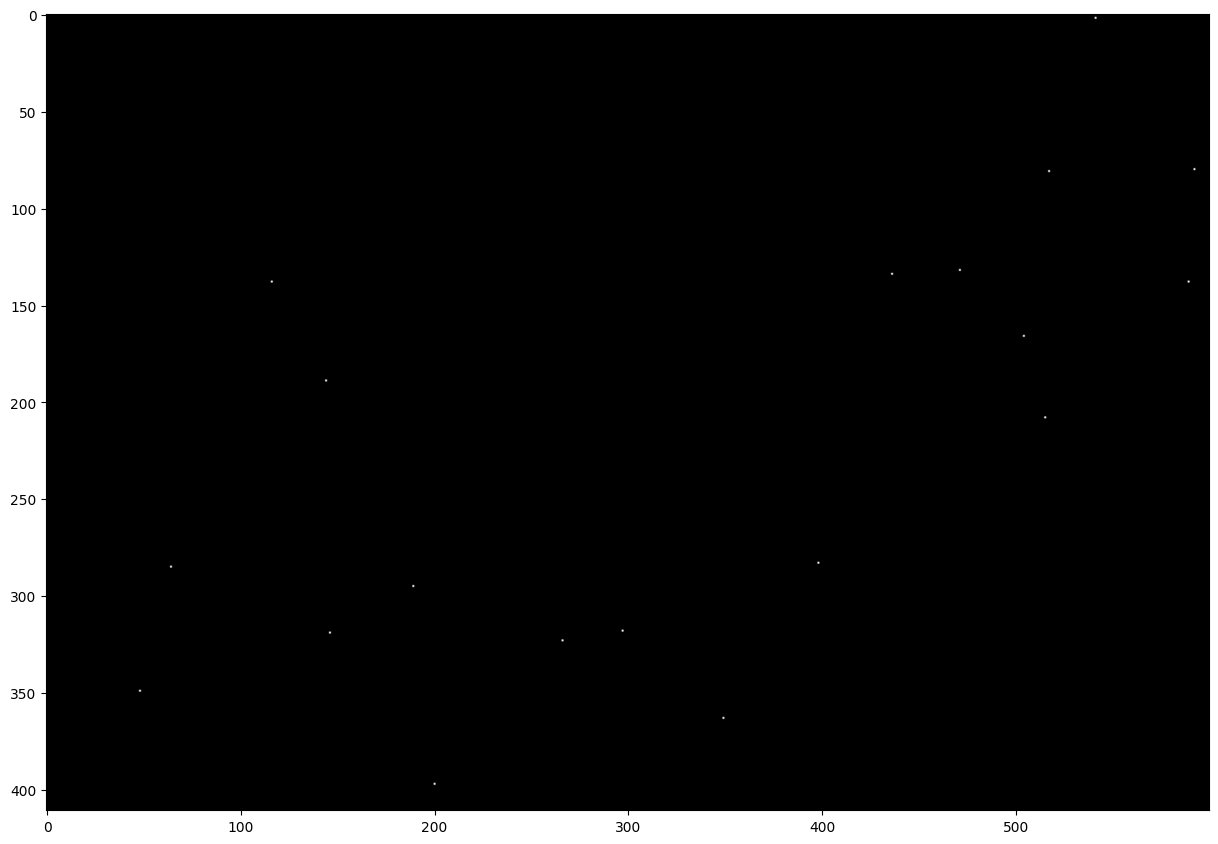

In [ ]:
# Construct the structuring element
s8 = np.array((
        [1, 0, 0],
        [0, 1, 1],
        [1, 0, 0]), dtype="int")


# Apply hit-or-miss transformation
img_s2_4 = ndimage.binary_hit_or_miss(thinned, structure1=s8).astype(int)
plt.figure(figsize=(15,15))
plt.imshow(img_s2_4, cmap = 'gray')

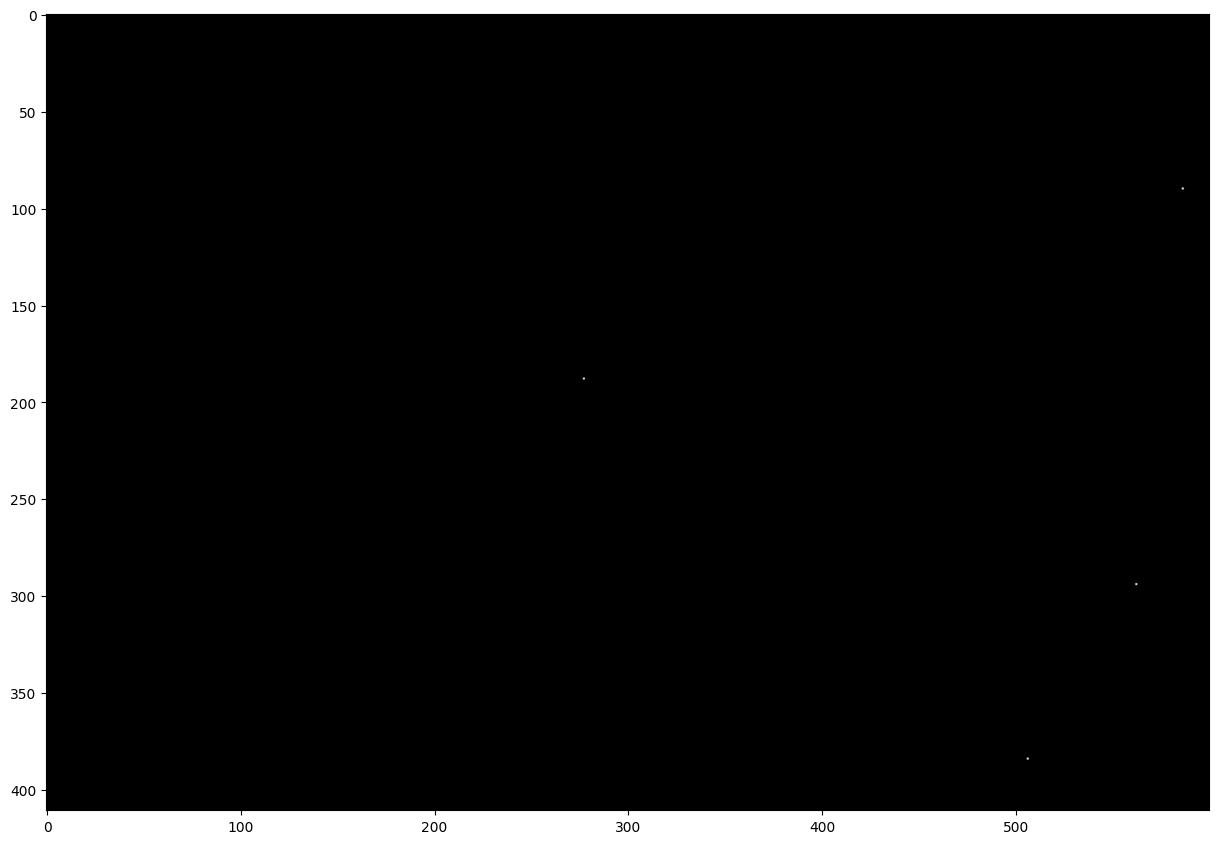

In [ ]:
# Construct the structuring element
s9 = np.array((
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 1]), dtype="int")


# Apply hit-or-miss transformation
img_s3_1 = ndimage.binary_hit_or_miss(thinned, structure1=s9).astype(int)
plt.figure(figsize=(15,15))
plt.imshow(img_s3_1, cmap = 'gray')

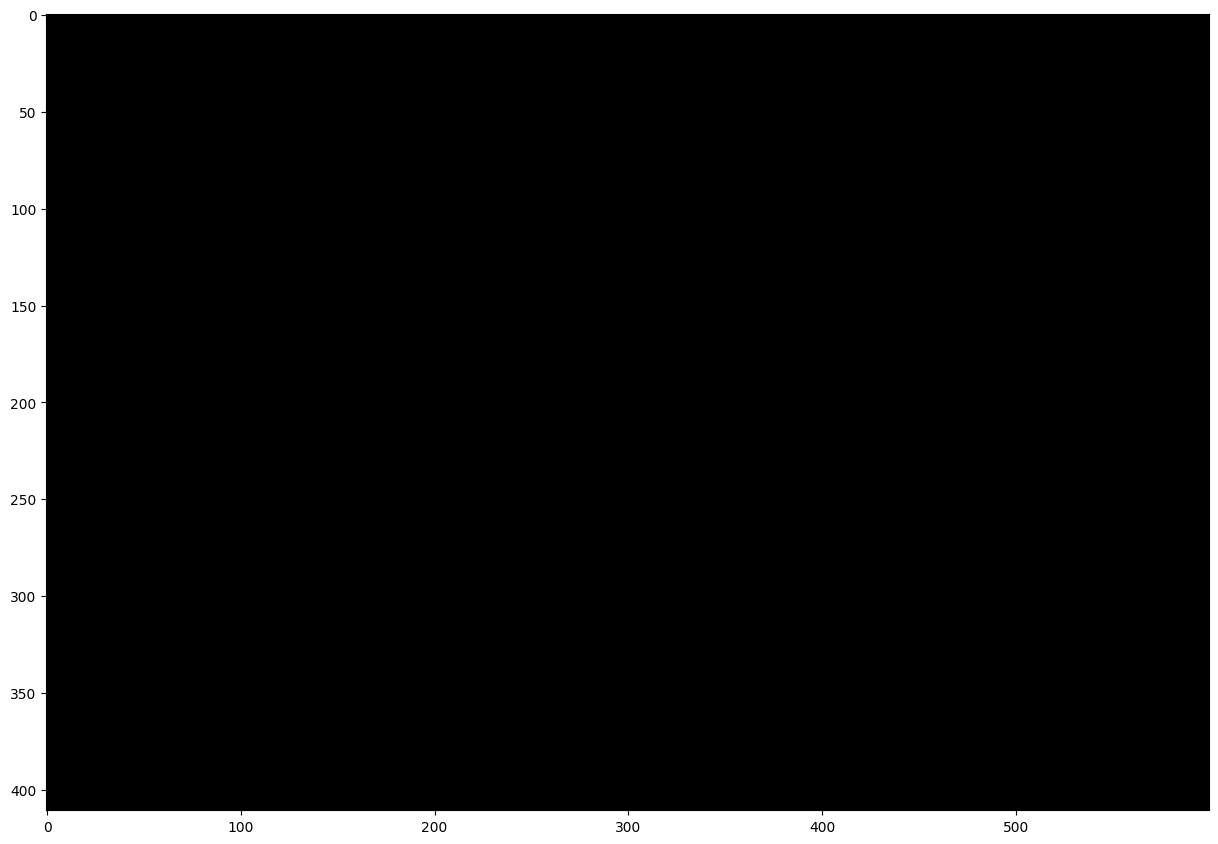

In [ ]:
# Construct the structuring element
s10 = np.array((
        [1, 0, 0],
        [0, 1, 0],
        [1, 0, 1]), dtype="int")


# Apply hit-or-miss transformation
img_s3_2 = ndimage.binary_hit_or_miss(thinned, structure1=s10).astype(int)
plt.figure(figsize=(15,15))
plt.imshow(img_s3_2, cmap = 'gray')

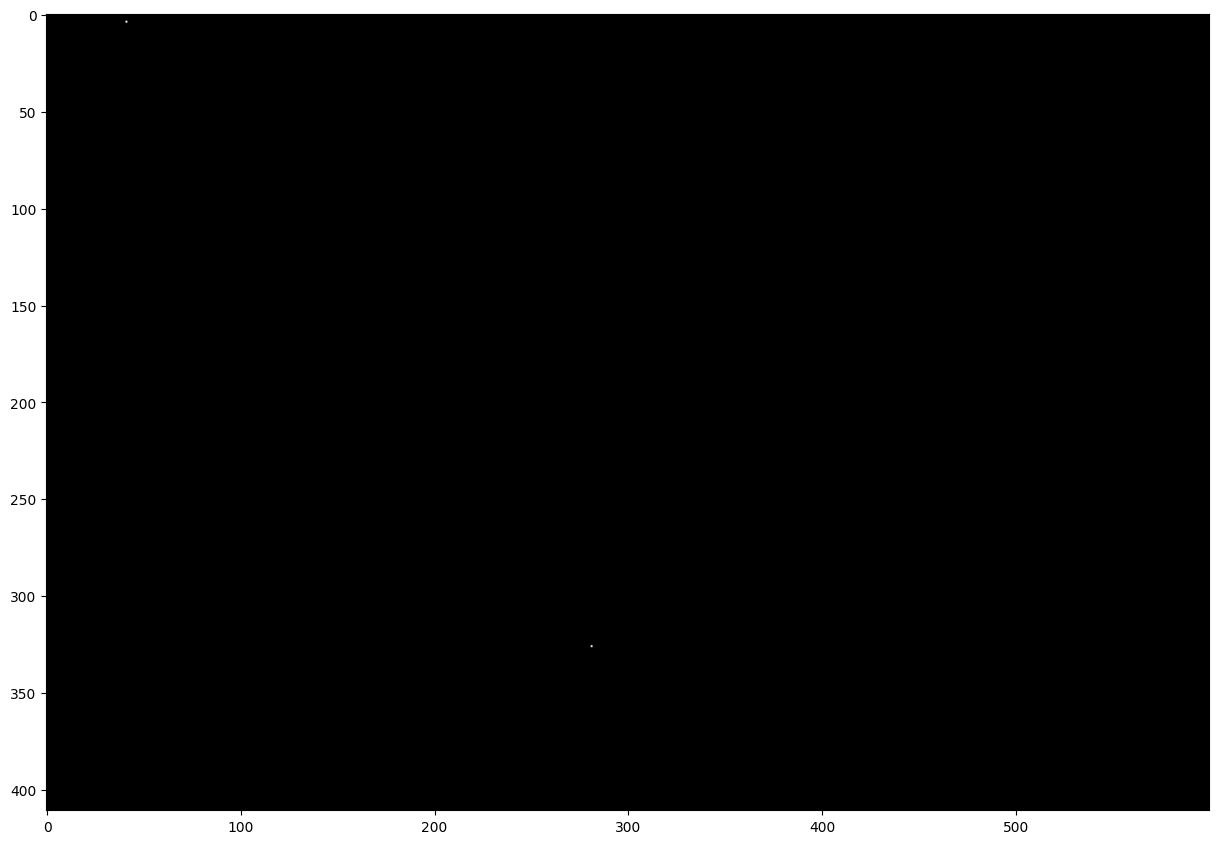

In [ ]:
# Construct the structuring element
s11 = np.array((
        [1, 0, 1],
        [0, 1, 0],
        [1, 0, 0]), dtype="int")


# Apply hit-or-miss transformation
img_s3_3 = ndimage.binary_hit_or_miss(thinned, structure1=s11).astype(int)
plt.figure(figsize=(15,15))
plt.imshow(img_s3_3, cmap = 'gray')

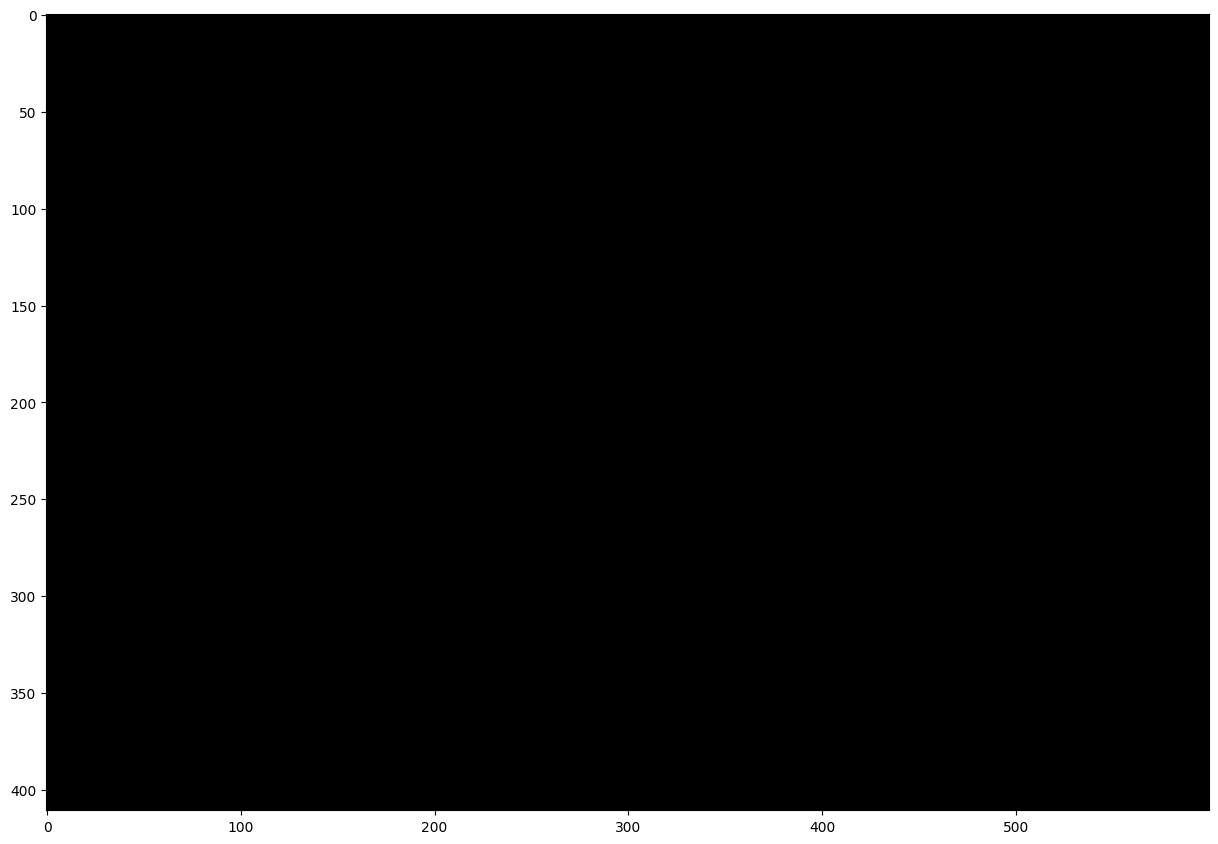

In [ ]:
# Construct the structuring element
s12 = np.array((
        [1, 0, 1],
        [0, 1, 0],
        [0, 0, 1]), dtype="int")


# Apply hit-or-miss transformation
img_s3_4 = ndimage.binary_hit_or_miss(thinned, structure1=s12).astype(int)
plt.figure(figsize=(15,15))
plt.imshow(img_s3_4, cmap = 'gray')

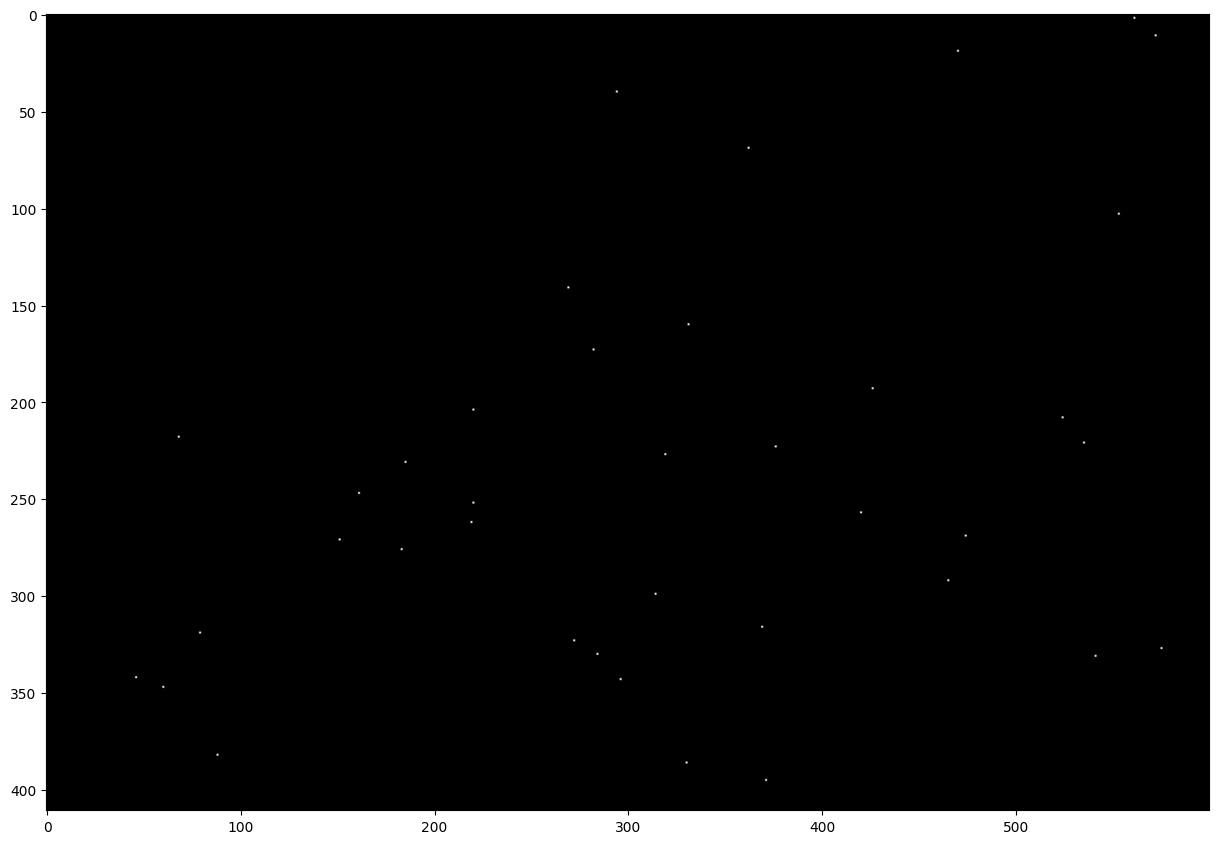

In [ ]:
# Construct the structuring element
s13 = np.array((
        [0, 0, 1],
        [1, 1, 0],
        [0, 1, 0]), dtype="int")


# Apply hit-or-miss transformation
img_s4_1 = ndimage.binary_hit_or_miss(thinned, structure1=s13).astype(int)
plt.figure(figsize=(15,15))
plt.imshow(img_s4_1, cmap = 'gray')

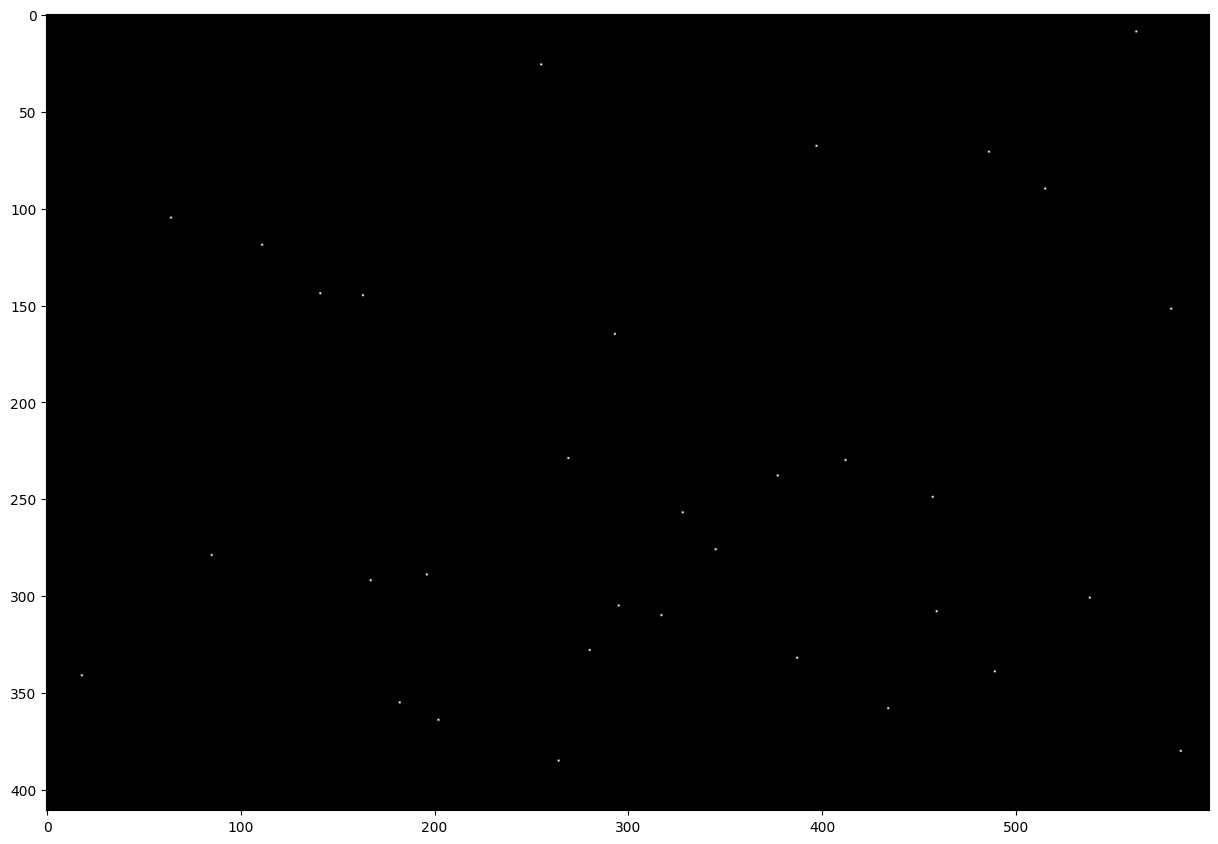

In [ ]:
# Construct the structuring element
s14 = np.array((
        [0, 1, 0],
        [1, 1, 0],
        [0, 0, 1]), dtype="int")


# Apply hit-or-miss transformation
img_s4_2 = ndimage.binary_hit_or_miss(thinned, structure1=s14).astype(int)
plt.figure(figsize=(15,15))
plt.imshow(img_s4_2, cmap = 'gray')

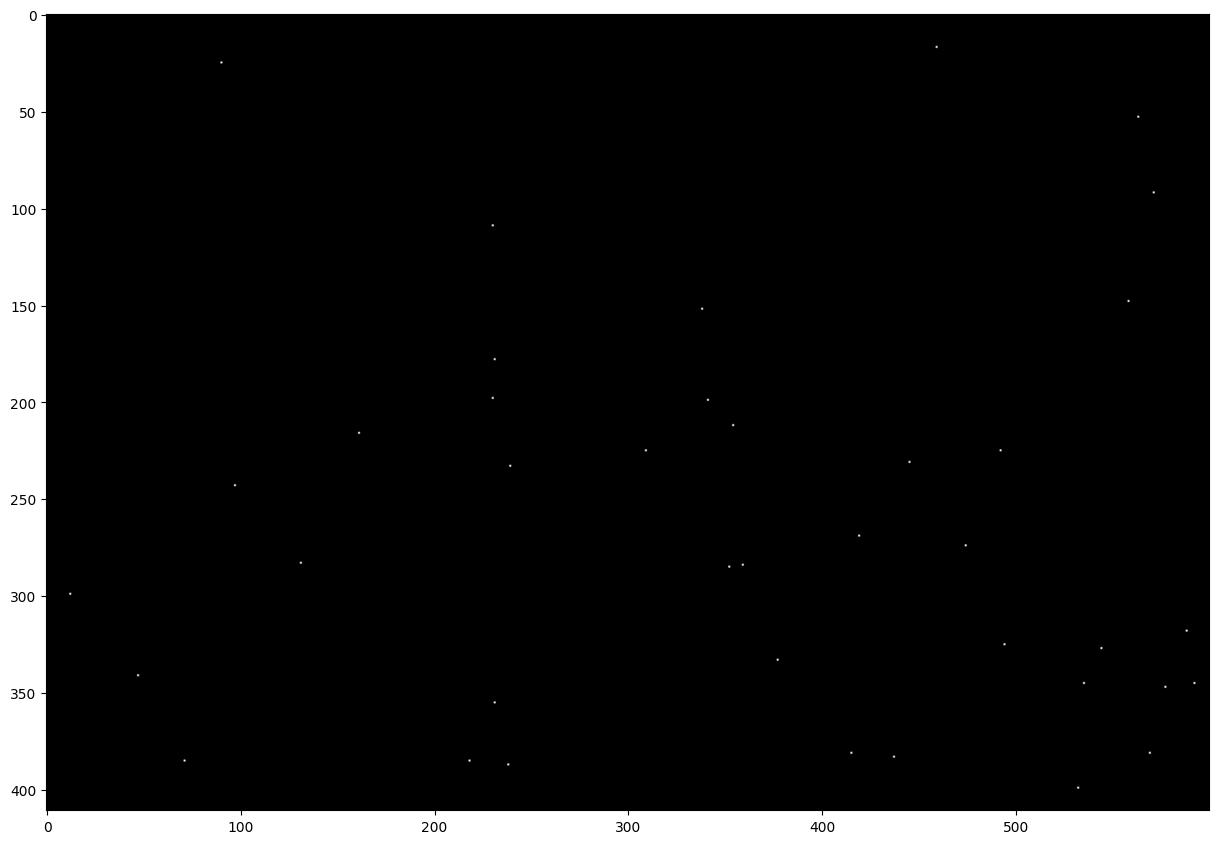

In [ ]:
# Construct the structuring element
s15 = np.array((
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0]), dtype="int")


# Apply hit-or-miss transformation
img_s4_3 = ndimage.binary_hit_or_miss(thinned, structure1=s15).astype(int)
plt.figure(figsize=(15,15))
plt.imshow(img_s4_3, cmap = 'gray')

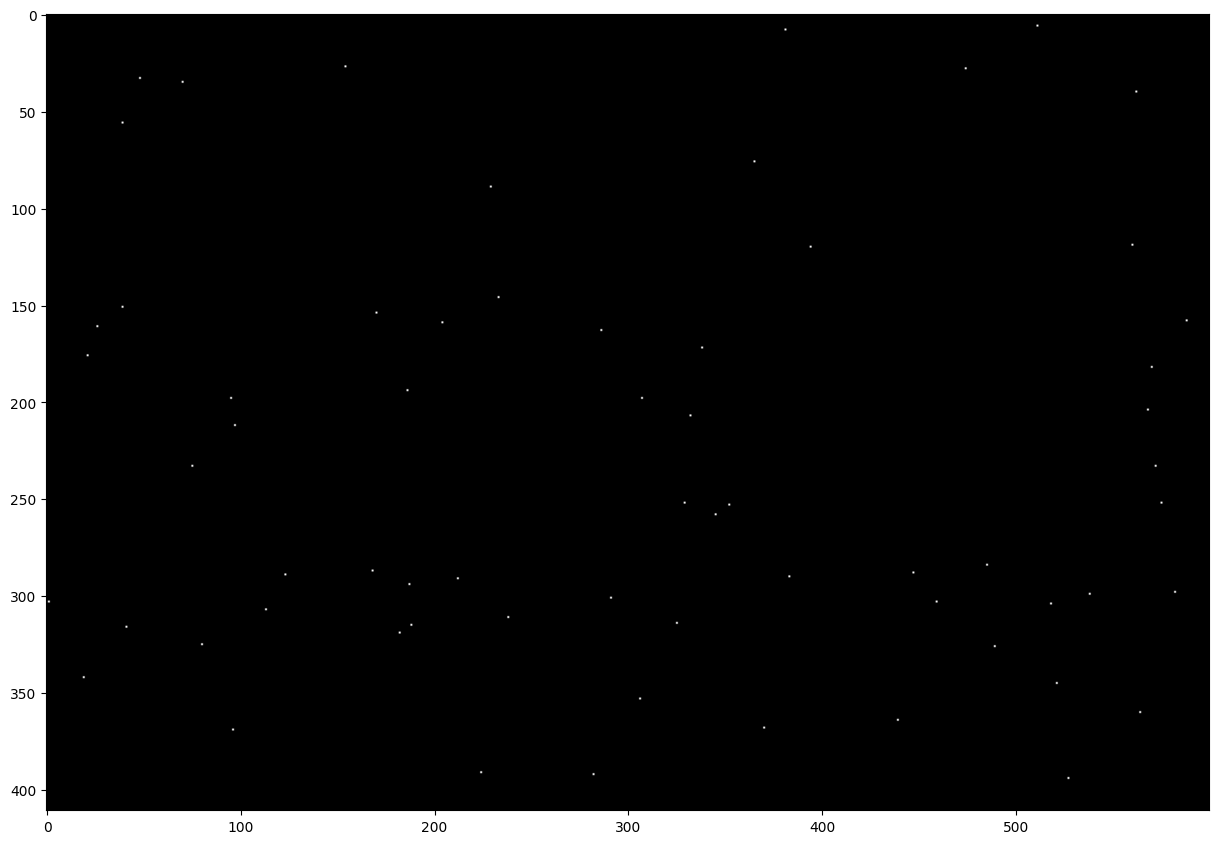

In [ ]:
# Construct the structuring element
s16 = np.array((
        [1, 0, 0],
        [0, 1, 1],
        [0, 1, 0]), dtype="int")


# Apply hit-or-miss transformation
img_s4_4 = ndimage.binary_hit_or_miss(thinned, structure1=s16).astype(int)
plt.figure(figsize=(15,15))
plt.imshow(img_s4_4, cmap = 'gray')

After getting the location of triple points in each of the orientation of all the structuring element, we will simply apply 'OR' (logical operation) in all these image together to get the final image that contain all the triple point location.

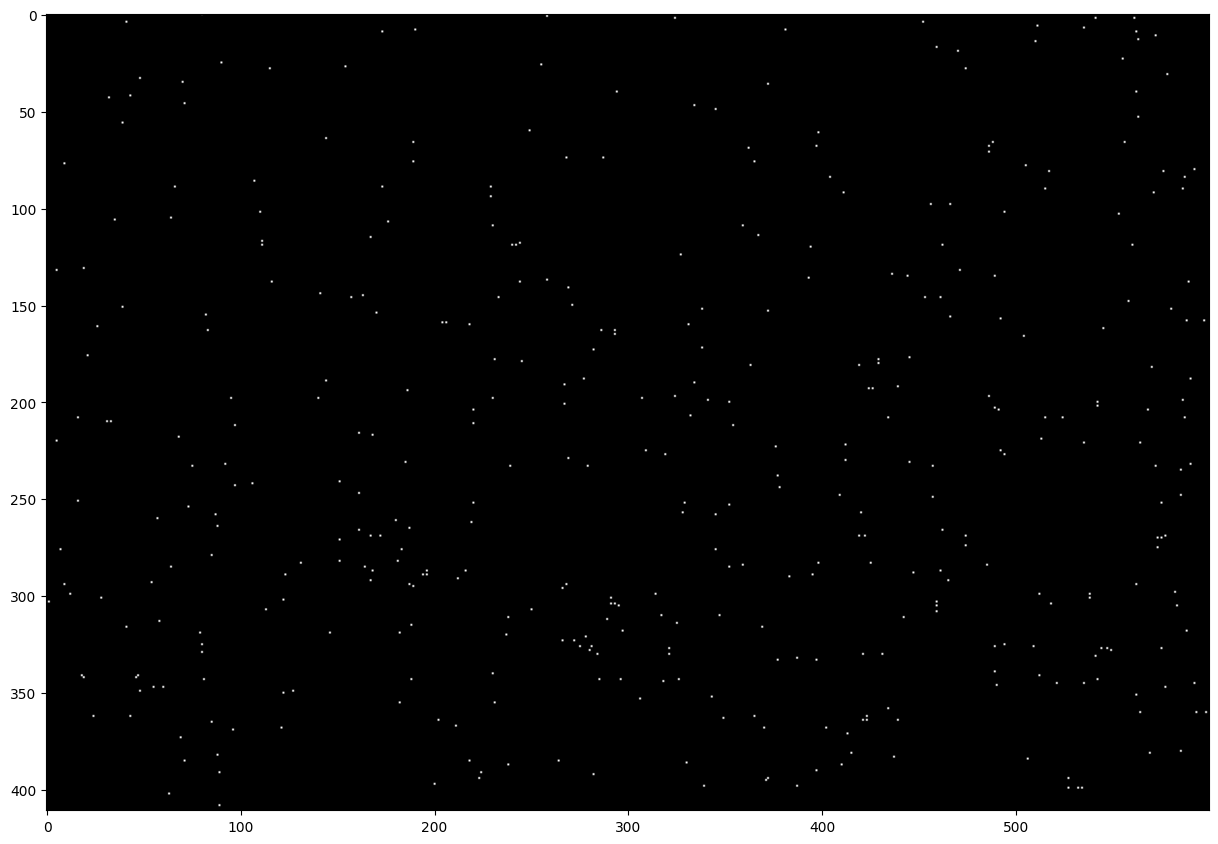

In [ ]:
#addition of all the 16 different image
img_final = img_s1_1 + img_s1_2 + img_s1_3 + img_s1_4 + img_s2_1 + img_s2_2 + img_s2_3 + img_s2_4 + img_s3_1 + img_s3_2 + img_s3_3 + img_s3_4 + img_s4_1 + img_s4_2 + img_s4_3 + img_s4_4
plt.figure(figsize=(15,15))
plt.imshow(img_final, cmap = 'gray')


Below code determines the total numbers of triple point and their co-ordinates.

In [ ]:
#determining the total number of triple point junction
pixels=[]
count=0
for i in range(img_final.shape[0]):
  for j in range(img_final.shape[1]):
    if img_final[i][j]==True:
      pixels.append((i,j))
      count=count+1

print("total number of triple junctions = ",count)


total number of triple junctions =  410


In [ ]:
#corodinate of triple junction
print("pixels that has triple junction",pixels)

pixels that has triple junction [(0, 80), (1, 258), (2, 324), (2, 541), (2, 561), (4, 41), (4, 452), (6, 511), (7, 535), (8, 190), (8, 381), (9, 173), (9, 562), (11, 572), (13, 563), (14, 510), (17, 459), (19, 470), (23, 555), (25, 90), (26, 255), (27, 154), (28, 115), (28, 474), (31, 578), (33, 48), (35, 70), (36, 372), (40, 294), (40, 562), (42, 43), (43, 32), (46, 71), (47, 334), (49, 345), (53, 563), (56, 39), (60, 249), (61, 398), (64, 144), (66, 189), (66, 488), (66, 556), (68, 397), (68, 486), (69, 362), (71, 486), (74, 268), (74, 287), (76, 189), (76, 365), (77, 9), (78, 505), (80, 592), (81, 517), (81, 576), (84, 404), (84, 587), (86, 107), (89, 66), (89, 173), (89, 229), (90, 515), (90, 586), (92, 411), (92, 571), (94, 229), (98, 456), (98, 466), (102, 110), (102, 494), (103, 553), (105, 64), (106, 35), (107, 176), (109, 230), (109, 359), (114, 367), (115, 167), (117, 111), (118, 244), (119, 111), (119, 240), (119, 242), (119, 462), (119, 560), (120, 394), (124, 327), (131, 1